##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Illustrating a book using Gemini 2.5 Image

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this guide, you are going to use multiple Gemini features (long context, multimodality, structured output, file API, chat mode...) in conjunction with the Gemini 2.5 image model (aka. nano banana) to illustrate a book.

Each concept will be explained along the way, but if you need a simpler introduction to Gemini Image generation model, check the [getting started](../quickstarts/Get_Started_Nano_Banana.ipynb) notebook, or the [Image generation documentation](https://ai.google.dev/gemini-api/docs/image-generation).

Note: for the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

Also note that this notebook used to use [Imagen](https://ai.google.dev/gemini-api/docs/imagen) models instead of Gemini 2.5 Image. If you are interested in the Imagen version, checked-out this [old version](../../c604f672f621186f609b1d977a918250eaca19f2/examples/Book_illustration.ipynb).

<!-- Princing warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#f5949e">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#f5949e">
      <h3><font color=black>Image generation is a paid-only feature and won't work if you are on the free tier. Check the <a href="https://ai.google.dev/pricing#Gemini 2.5 Image3"><font color='#217bfe'>pricing</font></a> page for more details.</font></h3>
    </td>
  </tr>
</table>

## 0/ Setup

This section install the SDK, set it up using your [API key](../quickstarts/Authentication.ipynb), imports the relevant libs, downloads the sample videos and upload them to Gemini.

Just collapse (click on the little arrow on the left of the title) and run this section if you want to jump straight to the examples (just don't forget to run it otherwise nothing will work).

### Install SDK


In [ ]:
%pip install -U -q "google-genai"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.7/244.7 kB 5.7 MB/s eta 0:00:00


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://link_to_vertex_AI)). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Imports

Some imports to display markdown text and images in Colab.

In [ ]:
import json
from PIL import Image
from IPython.display import display, Markdown

### Select models

In [ ]:
IMAGE_MODEL_ID = "gemini-2.5-flash-image"  # @param ["gemini-2.5-flash-image", "gemini-3-pro-image-preview"] {"allow-input":true, isTemplate: true}
GEMINI_MODEL_ID = "gemini-2.5-flash" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-3-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

For the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

In [ ]:
max_character_images = 3 # @param {type:"integer",isTemplate: true, min:1}
max_chapter_images = 3 # @param {type:"integer",isTemplate: true, min:1}

# Illustrate a book: The Wind in the Willows

## 1/ Get a book and upload using the File API

Start by downloading a book from the open-source [Project Gutenberg](www.gutenberg.org) library. For example, it can be [The Wind in the Willows](https://en.wikipedia.org/wiki/The_Wind_in_the_Willows) from Kenneth Grahame.

`client.files.upload` is used to upload the file so that Gemini can easily access it.

In [ ]:
import requests

url = "https://www.gutenberg.org/cache/epub/289/pg289.txt"  # @param {type:"string"}

response = requests.get(url)
with open("book.txt", "wb") as file:
    file.write(response.content)

book = client.files.upload(file="book.txt")


## 2/ Start the chat

You are going to use [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here so that Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time. More details on chat mode in the [Get Started](https://colab.sandbox.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb#scrollTo=b6sB7W-jdGxJ) notebook.

You should also define the format of the output you want using [structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json). You will mainly use Gemini to generate prompts so let's define a Pydantic model with two fields, a name and a prompt:

In [ ]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


`client.chats.create` starts the chat and defines its main parameters (model and the output you want).

In [ ]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=GEMINI_MODEL_ID,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(
    [
        "Here's a book, to illustrate using Gemini 2.5 Image. Don't say anything for now, instructions will follow.",
        book
    ]
);

The first message sent to the model is just to give it a bit of context ("*to illustrate using Gemini 2.5 Image*"), and more importantly give it the book.

It could have been done during the next step, especially since you're not interested in what the model has to say this time, but splitting the two steps makes it clearer.

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [ ]:
style = "" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style=="":
  response = chat.send_message("""
    Can you define a art style that would fit the story?
    Just give us the prompt for the art syle that will added to the furture prompts.
    """)
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f"""
    The art style will be:"{style}".
    Keep that in mind when generating future prompts.
    Keep quiet for now, instructions will follow.
  """)

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

Classic storybook illustration, gentle whimsical realism, soft watercolor and pen-and-ink style, with warm, inviting lighting and rich detail, depicting anthropomorphic animals in the English countryside.


Let's also define some more instructions which will act as "system instructions" or a negative prompt to tell the model what you do not want to see (text on the images).

In [ ]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
  Each produced should be a simple image, no panels.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

Ask Gemini to describe each of the main characters (excluding children as Gemini 2.5 Image can't generate images of them) and check that the output follows the format requested.


In [ ]:
response = chat.send_message("""
  Can you describe the main characters (only the adults) and
  prepare a prompt describing them with as much details as possible (use the descriptions from the book)
  so Gemini 2.5 Image can generate images of them? Each prompt should be at least 50 words.
""")

characters = json.loads(response.text)

print(json.dumps(characters, indent=4))

[
    {
        "name": "Mole",
        "prompt": "A small, good-hearted anthropomorphic mole with black fur, showing faint splashes of whitewash from spring-cleaning. He has a keen, curious expression, often appearing wide-eyed and easily excited by new discoveries like the river. When wet, he is a 'squashy, pulpy lump of misery' or has a 'bedraggled appearance.' He is loyal, eager, and appreciative of home comforts, sometimes timid but capable of bravery when pushed, beaming with delight at familiar objects."
    },
    {
        "name": "Water Rat",
        "prompt": "A sociable, good-natured anthropomorphic Water Rat with small, neat ears and thick, silky brown hair. He embodies a love for the river, often seen sculling or preparing for outings. His eyes are clear, dark, and brown, though they can sometimes appear glazed and shifting grey when under a powerful spell. He possesses a practical and observant demeanor, yet also has a dreamy, poetic side, capable of being stern but alwa

Now that you have the prompts, you just need to loop on all the characters and have Gemini 2.5 Image generate an image for them. This model uses the same API as the text generation models.

Like before, for the sake of consistency, we are going to use chat mode, but within a different instance.

For an extensive explanation on the Gemini 2.5 Image model and its options, check the [getting started with Gemini 2.5 Image](../quickstarts/Get_Started_Nano_Banana.ipynb) notebook. But here's a quick overview of what being used here:
* `prompt` is the prompt passed down to Gemini 2.5 Image. You're not just sending what Gemini has generate to describe the chacaters but also our style and our system instructions.
* `response_modalities=['Image']` because we only want images
* `aspect_ratio="9:16"` because we want portraits images

Note that we could have used system instructions but the model currently ignores them so we decided to pass them as message.

### Mole

A small, good-hearted anthropomorphic mole with black fur, showing faint splashes of whitewash from spring-cleaning. He has a keen, curious expression, often appearing wide-eyed and easily excited by new discoveries like the river. When wet, he is a 'squashy, pulpy lump of misery' or has a 'bedraggled appearance.' He is loyal, eager, and appreciative of home comforts, sometimes timid but capable of bravery when pushed, beaming with delight at familiar objects.

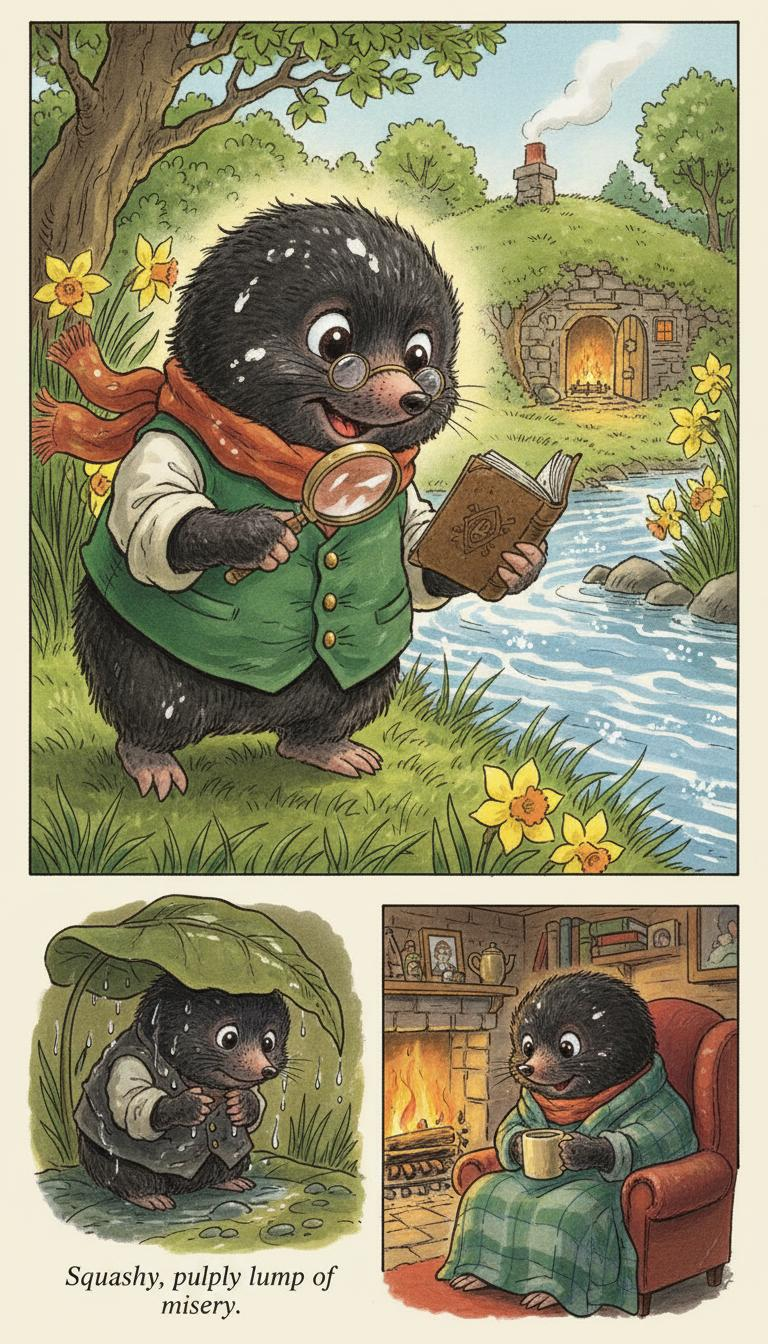

### Water Rat

A sociable, good-natured anthropomorphic Water Rat with small, neat ears and thick, silky brown hair. He embodies a love for the river, often seen sculling or preparing for outings. His eyes are clear, dark, and brown, though they can sometimes appear glazed and shifting grey when under a powerful spell. He possesses a practical and observant demeanor, yet also has a dreamy, poetic side, capable of being stern but always a loyal and responsible friend to Mole.

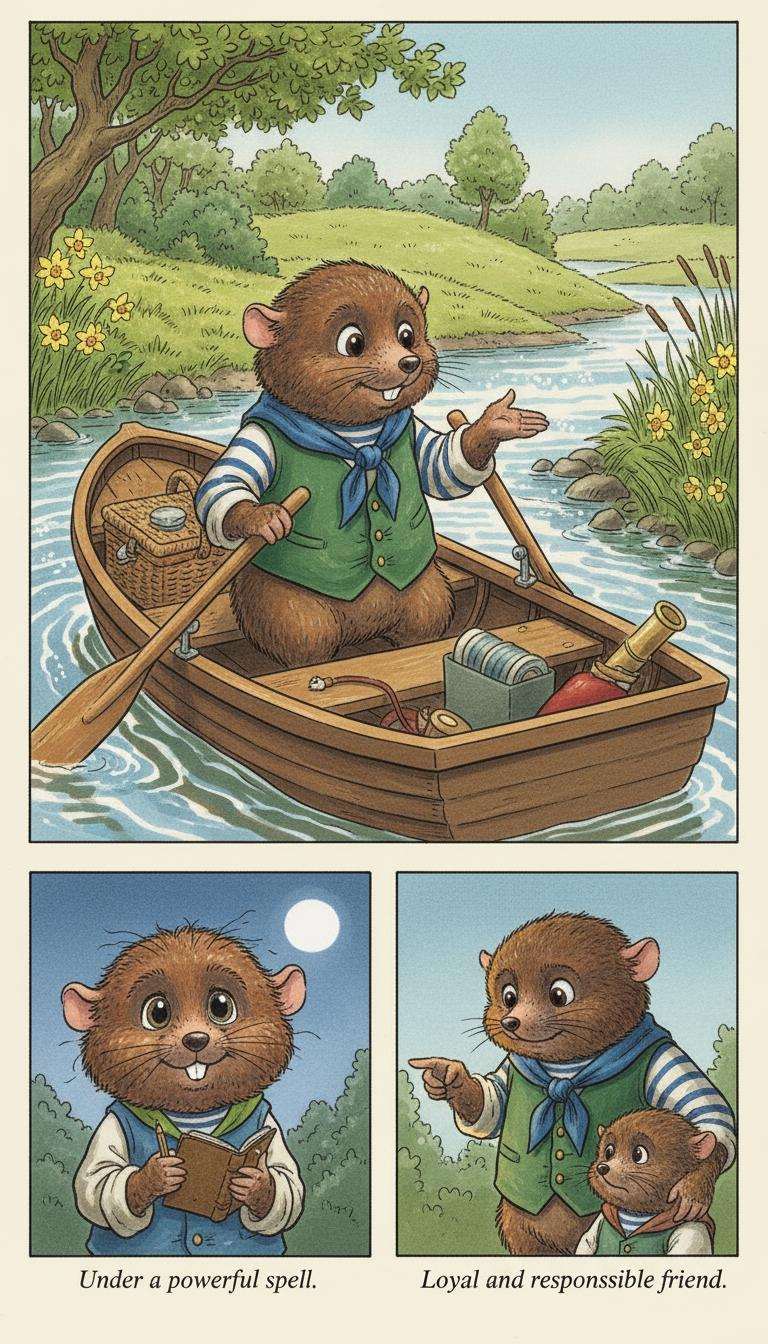

### Mr. Toad

A short, stout anthropomorphic toad, prone to dramatic shifts in emotion and appearance. He is often depicted in eccentric motor-car attire including goggles, cap, gaiters, and an enormous overcoat, or in a comical washerwoman's disguise with a squat figure, cotton print gown, and rusty black bonnet. His expression ranges from boastful, conceited, and self-important to terrified, self-pitying, and filled with a furious, swollen pride. Despite his flaws, he is ultimately good-hearted.

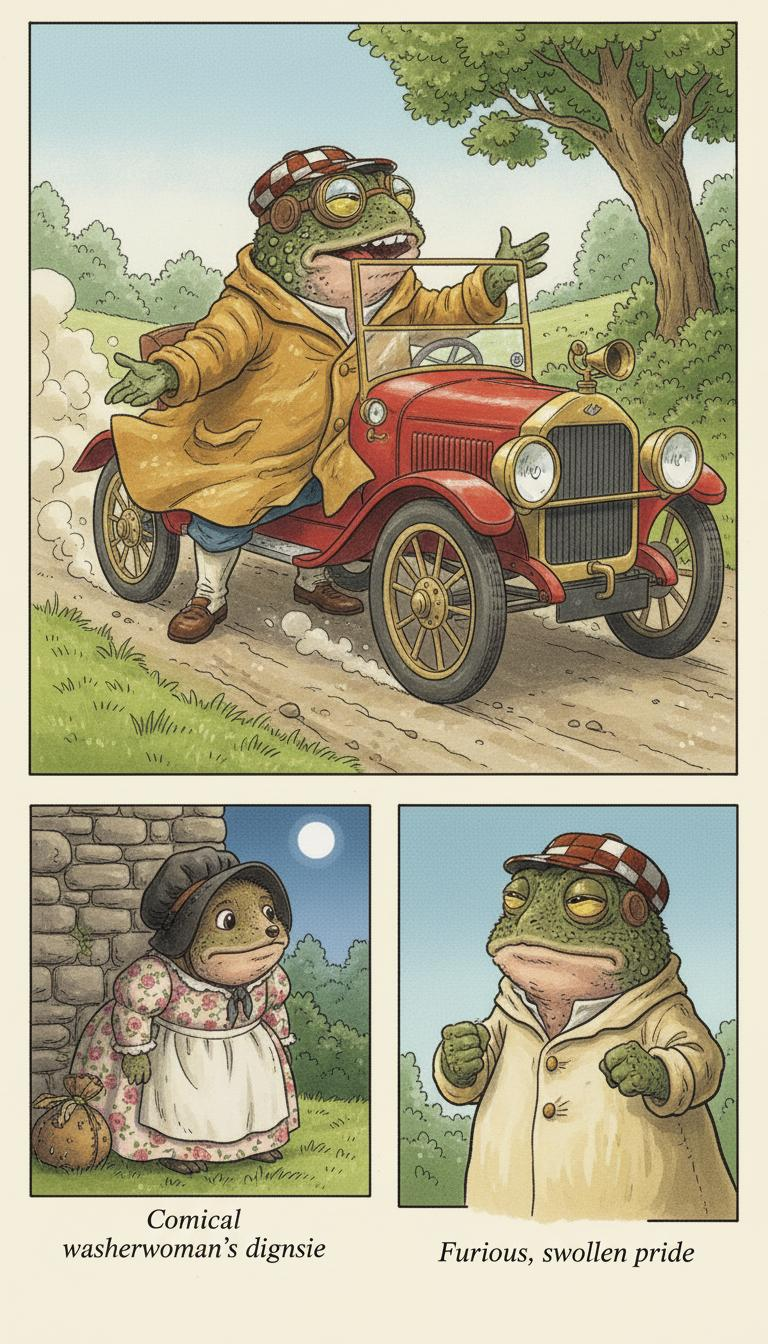

In [ ]:
image_chat = client.chats.create(
    model=IMAGE_MODEL_ID,
    config=types.GenerateContentConfig(
        response_modalities=["IMAGE"],
        image_config=types.ImageConfig(
            aspect_ratio="9:16"
        )
    )
)

image_chat.send_message(f"""
  You are going to generate portrait images to illustrate The Wind in the Willows from Kenneth Grahame.
  The style we want you to follow is: {style}
  Also follow those rules: {system_instructions}
""")

for character in characters[:max_character_images]:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  response = image_chat.send_message(f"Create an illustration for {character['name']} following this description: {character['prompt']}")

  for part in response.parts:
    if part.inline_data:
      generated_image = part.as_image()
      generated_image.show()
      break

# Be careful; long output (see below)

## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Gemini 2.5 Image to generate images based on those prompts.

In [ ]:
response = chat.send_message("Now, for each chapters of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Be very descriptive and remember to tell their name and to reuse the character prompts if they appear in the images. Each character should at least be described with 30 words.")

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter I. The River Bank",
        "prompt": "Classic storybook illustration, gentle whimsical realism, soft watercolor and pen-and-ink style, with warm, inviting lighting and rich detail, depicting anthropomorphic animals in the English countryside. A small, good-hearted anthropomorphic mole with black fur, Mole (showing faint splashes of whitewash from spring-cleaning, his eyes wide with wonder, eager and appreciative of new experiences), sits on a sun-drenched riverbank, trailing a paw in the water. Beside him, a sociable, good-natured anthropomorphic Water Rat (with small, neat ears and thick, silky brown hair, his dark and clear eyes gazing dreamily), sculls a small blue and white boat across the sparkling river. In the distance, a broad, glistening muzzle of Otter (a cheerful and social anthropomorphic otter with strong, white teeth, familiar with all river paths), emerges from the river, approaching the bank."
    },
    {
        "name": "Chapter II. T

### Chapter I. The River Bank

Classic storybook illustration, gentle whimsical realism, soft watercolor and pen-and-ink style, with warm, inviting lighting and rich detail, depicting anthropomorphic animals in the English countryside. A small, good-hearted anthropomorphic mole with black fur, Mole (showing faint splashes of whitewash from spring-cleaning, his eyes wide with wonder, eager and appreciative of new experiences), sits on a sun-drenched riverbank, trailing a paw in the water. Beside him, a sociable, good-natured anthropomorphic Water Rat (with small, neat ears and thick, silky brown hair, his dark and clear eyes gazing dreamily), sculls a small blue and white boat across the sparkling river. In the distance, a broad, glistening muzzle of Otter (a cheerful and social anthropomorphic otter with strong, white teeth, familiar with all river paths), emerges from the river, approaching the bank.

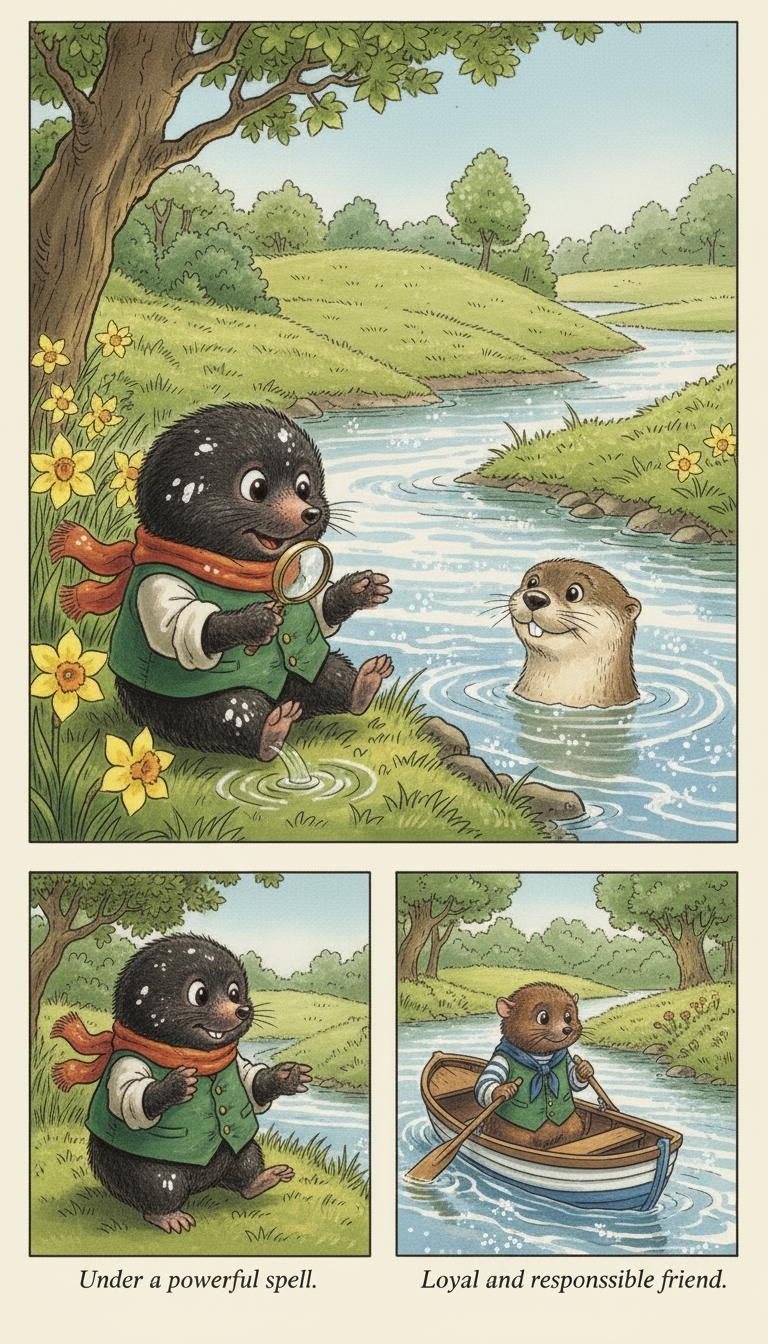

### Chapter II. The Open Road

Classic storybook illustration, gentle whimsical realism, soft watercolor and pen-and-ink style, with warm, inviting lighting and rich detail, depicting anthropomorphic animals in the English countryside. Mr. Toad (a short, stout anthropomorphic toad, prone to dramatic shifts in emotion and appearance, currently filled with boastful, conceited self-importance), enthusiastically gestures towards his new canary-yellow gypsy caravan with green trim and red wheels. The caravan lies wrecked in a ditch. Mr. Toad sits in the dusty road, eyes fixed on a vanishing, magnificent, immense red motor-car (a dramatic speck in the distance), murmuring 'Poop-poop!' with a look of blissful obsession. Nearby, the Mole (a small, good-hearted anthropomorphic mole with black fur, looking disheartened, his eagerness tempered by recent disaster), and the Water Rat (a sociable, good-natured anthropomorphic Water Rat with small, neat ears and thick, silky brown hair, expressing exasperation), survey the damage.

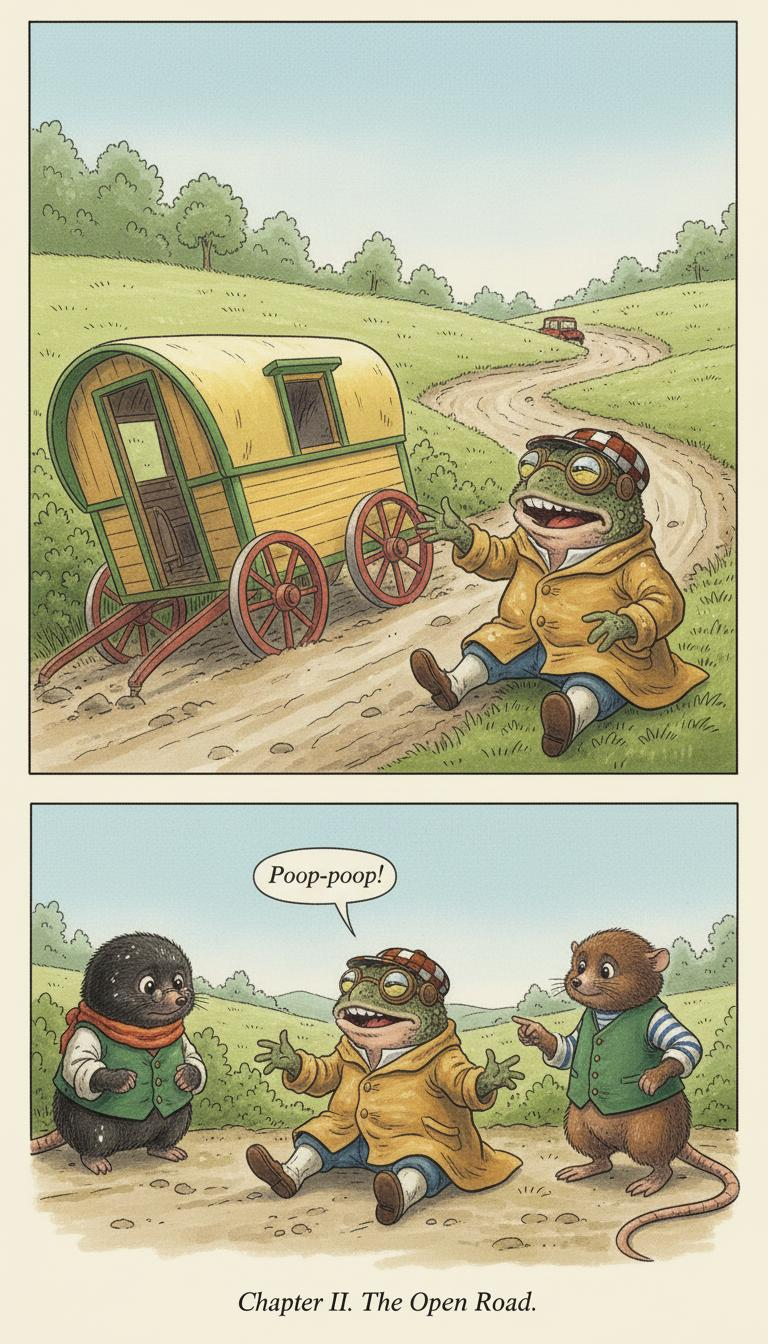

### Chapter III. The Wild Wood

Classic storybook illustration, gentle whimsical realism, soft watercolor and pen-and-ink style, with warm, inviting lighting and rich detail, depicting anthropomorphic animals in the English countryside. In the deep, dark, snow-covered Wild Wood, the Mole (a small, good-hearted anthropomorphic mole with black fur, now terrified and shivering, his previous curiosity replaced by dread), hides trembling in the hollow of an old beech tree. Unseen menacing figures with hard eyes peer from shadowy holes in the trees and snow. The Water Rat (a sociable, good-natured anthropomorphic Water Rat with small, neat ears and thick, silky brown hair, his clear, dark eyes now serious and determined), armed with a stout cudgel and pistols strapped to his waist, carefully makes his way through the falling snow, anxiously searching for his friend.

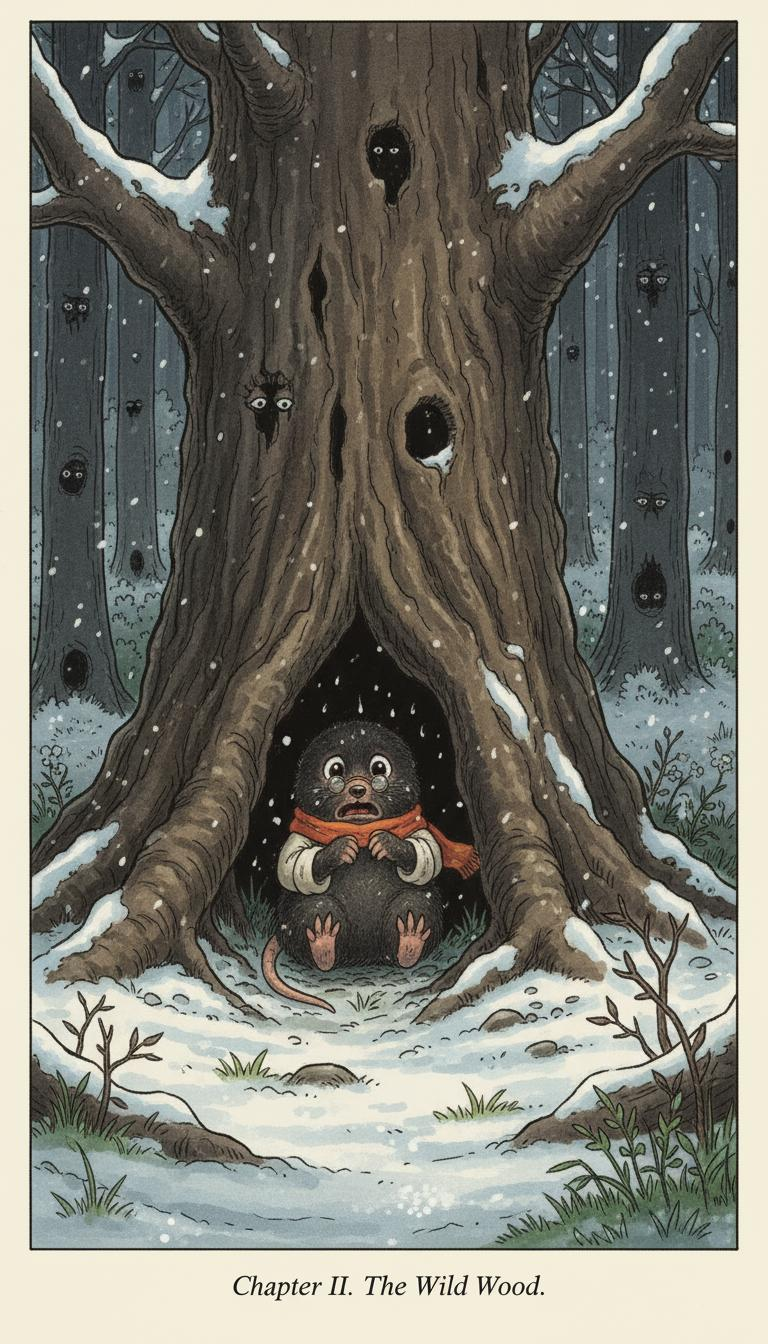

In [ ]:
image_chat.send_message("Starting from now, we're going to illustrate the book's chapters. Don't forget to refer to your previous illustrations of the characters to keep the characters consistency, but feel free to change their position.")

for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  response = image_chat.send_message(f"Create an illustration for {chapter['name']} using the previously generated characters following this description: {chapter['prompt']}")

  for part in response.parts:
    if part.inline_data:
      generated_image = part.as_image()
      generated_image.show()
      break

# Be careful; long output (see below)

# With an Audiobook: The Adventures of Chatterer the Red Squirrel

This time, you are going to use an audiobook as the source, and in this case *The Adventures of Chatterer the Red Squirrel* audiobook from the open-source library [Librivox](https://librivox.org/the-adventures-of-chatterer-the-red-squirel-by-thornton-w-burgess/).

## 1/ Get the audiobook and merge its chapters
You could upload all the chapters one by one, but it's easier to merge all the chapters together befor uploading the audiobook and only deal with one file.

For the sake of the length of the demonstration, you will only merge the first 5 chapters, but feel free to update the code and try on the full book.

In [ ]:
%pip install pydub
import os
import zipfile
from pydub import AudioSegment

# Download the zip file
!wget https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip

# Unzip the file
with zipfile.ZipFile("chatterertheredsquirrel_1307_librivox_64kb_mp3.zip", 'r') as zip_ref:
    zip_ref.extractall("audiobook")

# Get a list of all MP3 files in the extracted folder
mp3_files = [f for f in os.listdir("audiobook") if f.endswith('.mp3')]

mp3_files.sort()

if len(mp3_files) > 1:
    combined_audio = AudioSegment.empty()
    for i in range(min(5, len(mp3_files))):  # Limit to 5 or fewer chapters
        mp3_file = mp3_files[i]  # Get the filename using the index
        combined_audio += AudioSegment.from_mp3(os.path.join("audiobook", mp3_file))
    combined_audio.export("audiobook.mp3", format="mp3")
    print("MP3 files merged into audiobook.mp3")
else:
    print("Only one MP3 file found, no merging needed.")

--2025-10-01 09:03:45--  https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving www.archive.org (www.archive.org)... 207.241.224.2
Connecting to www.archive.org (www.archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-10-01 09:03:45--  https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600105.us.archive.org/12/items/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-10-01 09:03:45--  https://ia600

Now upload it using the File API:

In [ ]:
audiobook = client.files.upload(file="audiobook.mp3")

## 2/ Start the chat

Oonce again, using [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here let Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time.

[Structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) is used to force Gemini to output nice lists of prompts.

In [ ]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


In [ ]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=GEMINI_MODEL_ID,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(["Here's an audiobook, to illustrate using Gemini 2.5 Image. Don't say anything for now, instructions will follow.",audiobook]);

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly. That's what is illustrated here with a futuristic style.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [ ]:
style = "futuristic, science fiction, utopia, saturated, neon lights" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style == "":
  response = chat.send_message("Can you define a art style that would fit the story? Just give us the prompt for the art syle that will added to the furture prompts.")
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f'The art style will be:"{style}". Keep that in mind when generating future prompts. Keep quiet for now, instructions will follow.')

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

futuristic, science fiction, utopia, saturated, neon lights


In [ ]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
  Each produced should be a simple image, no panels.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

In [ ]:
response = chat.send_message(["Can you describe the main characters and prepare a prompt describing them with as much details as possible (use the descriptions from the book) so Gemini 2.5 Image can generate images of them?"])

characters = json.loads(response.text)

print(json.dumps(characters, indent=4))

[
    {
        "name": "Chatterer the Red Squirrel",
        "prompt": "A futuristic, anthropomorphic red squirrel with a sleek, vibrant red fur coat that subtly glows with neon accents. His fur is impeccably groomed, reflecting the utopian setting. He wears minimalist, functional sci-fi attire, perhaps small glowing wrist-communicators or jetpack-like elements. His eyes gleam with intelligence and a hint of mischief. The background features a pristine, futuristic forest with bioluminescent flora and neon-lit structures, all in saturated, vivid colors. He should appear agile and ready to spring into action, perhaps running or leaping across glowing branches. Art style: futuristic, science fiction, utopia, saturated, neon lights."
    },
    {
        "name": "Shadow the Weasel",
        "prompt": "A futuristic, anthropomorphic weasel with an unnervingly sleek and slender form, its body an almost liquid-like dark, metallic material that seems to absorb light, contrasting with striking 

/usr/local/lib/python3.12/dist-packages/google/genai/_common.py:493: UserWarning: NO_IMAGE is not a valid FinishReason
  warnings.warn(f"{value} is not a valid {cls.__name__}")


### Chatterer the Red Squirrel

A futuristic, anthropomorphic red squirrel with a sleek, vibrant red fur coat that subtly glows with neon accents. His fur is impeccably groomed, reflecting the utopian setting. He wears minimalist, functional sci-fi attire, perhaps small glowing wrist-communicators or jetpack-like elements. His eyes gleam with intelligence and a hint of mischief. The background features a pristine, futuristic forest with bioluminescent flora and neon-lit structures, all in saturated, vivid colors. He should appear agile and ready to spring into action, perhaps running or leaping across glowing branches. Art style: futuristic, science fiction, utopia, saturated, neon lights.

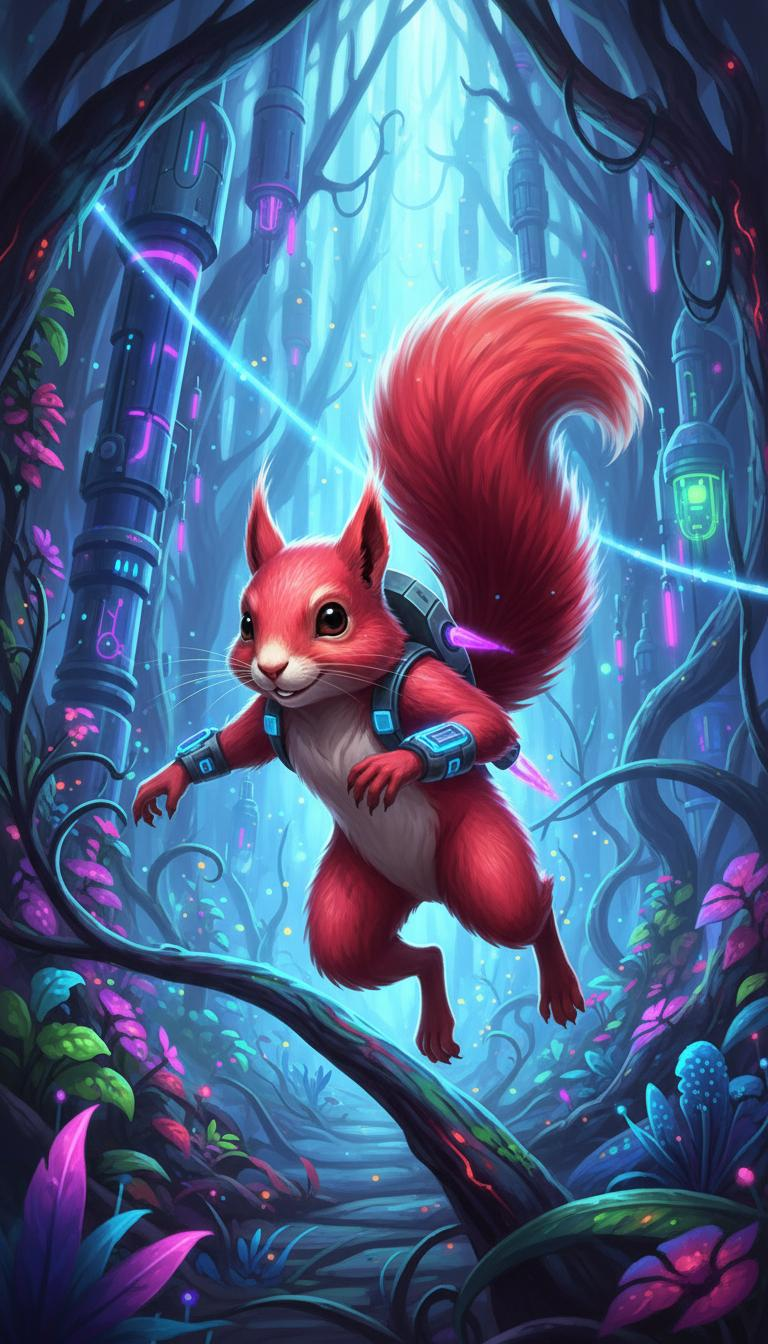

### Shadow the Weasel

A futuristic, anthropomorphic weasel with an unnervingly sleek and slender form, its body an almost liquid-like dark, metallic material that seems to absorb light, contrasting with striking neon red eyes that glow intensely with hunger and anger. Its movements are fluid and swift, suggesting advanced stealth capabilities. The weasel wears minimal, almost invisible, high-tech gear that enhances its agility, perhaps integrated optical camouflage. The background shows a dystopian-edge of the utopian setting, with shadowed alleys or tight, neon-lit corridors where it can easily maneuver, rendered in saturated, slightly darker tones with sharp neon highlights. Art style: futuristic, science fiction, utopia, saturated, neon lights.

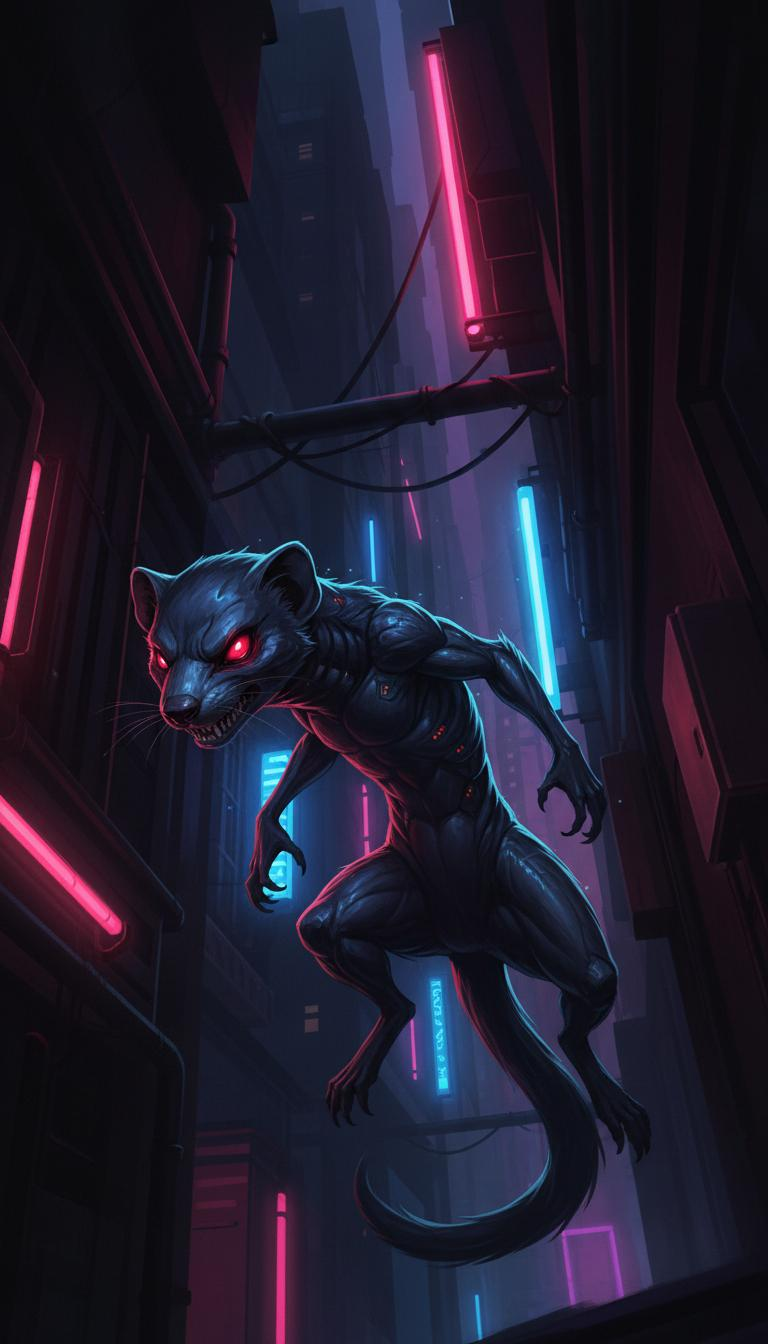

### Redtail the Hawk

A majestic, futuristic Redtail Hawk, its feathers a blend of deep crimson and metallic hues, with sharp, predatory eyes that glow with a fierce, cold light. It possesses cybernetic enhancements, perhaps subtle thrusters on its wings for swift, silent flight or augmented talons that are exceptionally sharp and cruel-looking. When angry, feathers on its head flare with intense neon energy, and it hisses with a digital snarl. It is poised for a swoop, its great claws extended, against a backdrop of towering, glowing utopian spires and aerial platforms, with saturated, vibrant colors, emphasizing its formidable presence. Art style: futuristic, science fiction, utopia, saturated, neon lights.

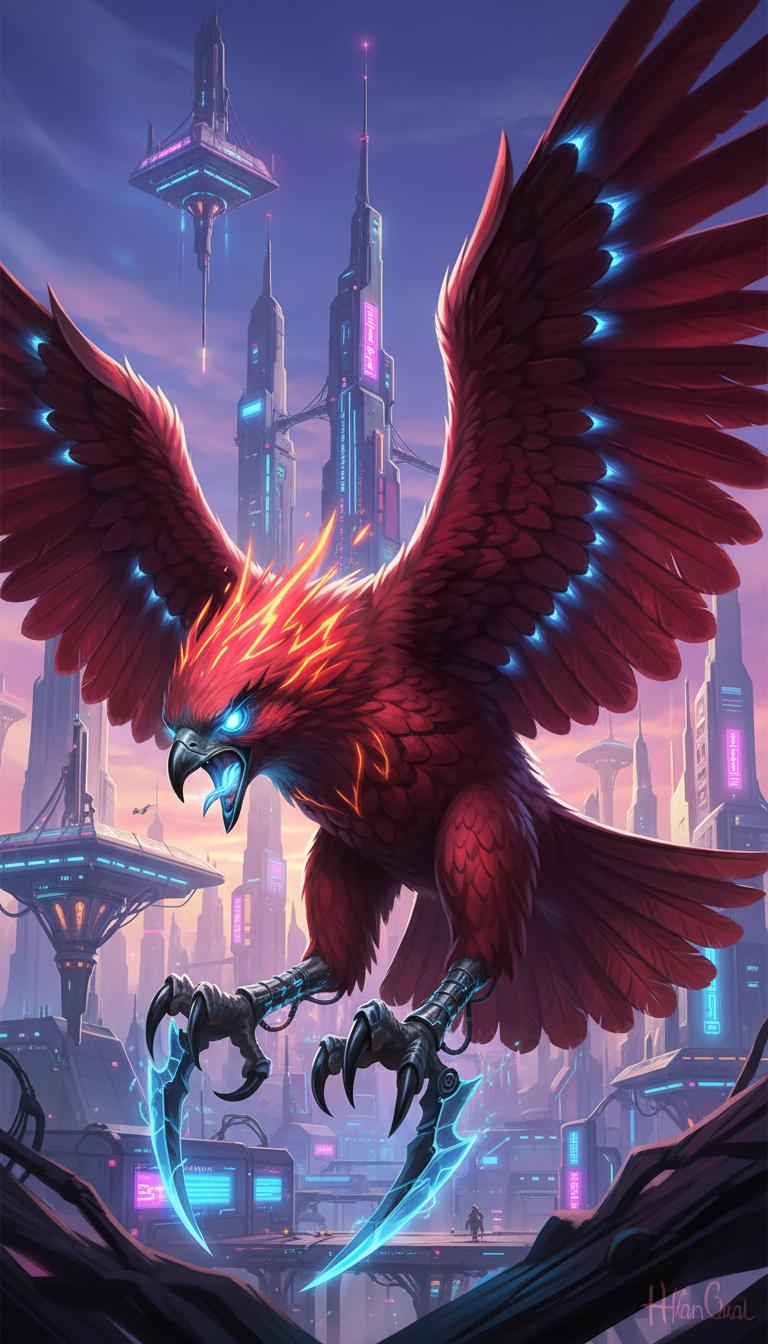

In [ ]:
image_chat = client.chats.create(
    model=IMAGE_MODEL_ID,
    config=types.GenerateContentConfig(
        response_modalities=["IMAGE"],
        image_config=types.ImageConfig(
            aspect_ratio="9:16"
        )
    )
)

image_chat.send_message(f"""
  You are going to generate portrait images to illustrate The Wind in the Willows from Kenneth Grahame.
  The style we want you to follow is: {style}
  Also follow those rules: {system_instructions}
""")

for character in characters[:max_character_images]:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  response = image_chat.send_message(f"Create an illustration for {character['name']} following this description: {character['prompt']}")

  for part in response.parts:
    if part.inline_data:
      generated_image = part.as_image()
      generated_image.show()
      break

# Be careful; long output (see below)

## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Gemini 2.5 Image to generate images based on those prompts.

In [ ]:
response = chat.send_message(["Now, for each chapter of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Remember to reuse the character prompts if they appear in the image"])

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter 1: Chatterer the Red Squirrel runs for his life",
        "prompt": "A desperate and tired Chatterer the Red Squirrel, a futuristic, anthropomorphic red squirrel with a sleek, vibrant red fur coat that subtly glows with neon accents, is running for his life, leaping across glowing branches in a futuristic forest. His eyes are wide with fear, and his sleek, minimalist sci-fi attire shows signs of wear from his frantic escape. In the shadowy background, barely perceptible but always present, is Shadow the Weasel, an unnervingly sleek and slender futuristic, anthropomorphic weasel with a dark, metallic body and intense neon red eyes that glow with hunger. The scene is full of saturated, vivid colors, with sharp neon highlights accentuating the speed and danger. Art style: futuristic, science fiction, utopia, saturated, neon lights."
    },
    {
        "name": "Chapter 2: Chatterer's Last Chance",
        "prompt": "A tense moment in a vibrant, futuristic

### Chapter 1: Chatterer the Red Squirrel runs for his life

A desperate and tired Chatterer the Red Squirrel, a futuristic, anthropomorphic red squirrel with a sleek, vibrant red fur coat that subtly glows with neon accents, is running for his life, leaping across glowing branches in a futuristic forest. His eyes are wide with fear, and his sleek, minimalist sci-fi attire shows signs of wear from his frantic escape. In the shadowy background, barely perceptible but always present, is Shadow the Weasel, an unnervingly sleek and slender futuristic, anthropomorphic weasel with a dark, metallic body and intense neon red eyes that glow with hunger. The scene is full of saturated, vivid colors, with sharp neon highlights accentuating the speed and danger. Art style: futuristic, science fiction, utopia, saturated, neon lights.

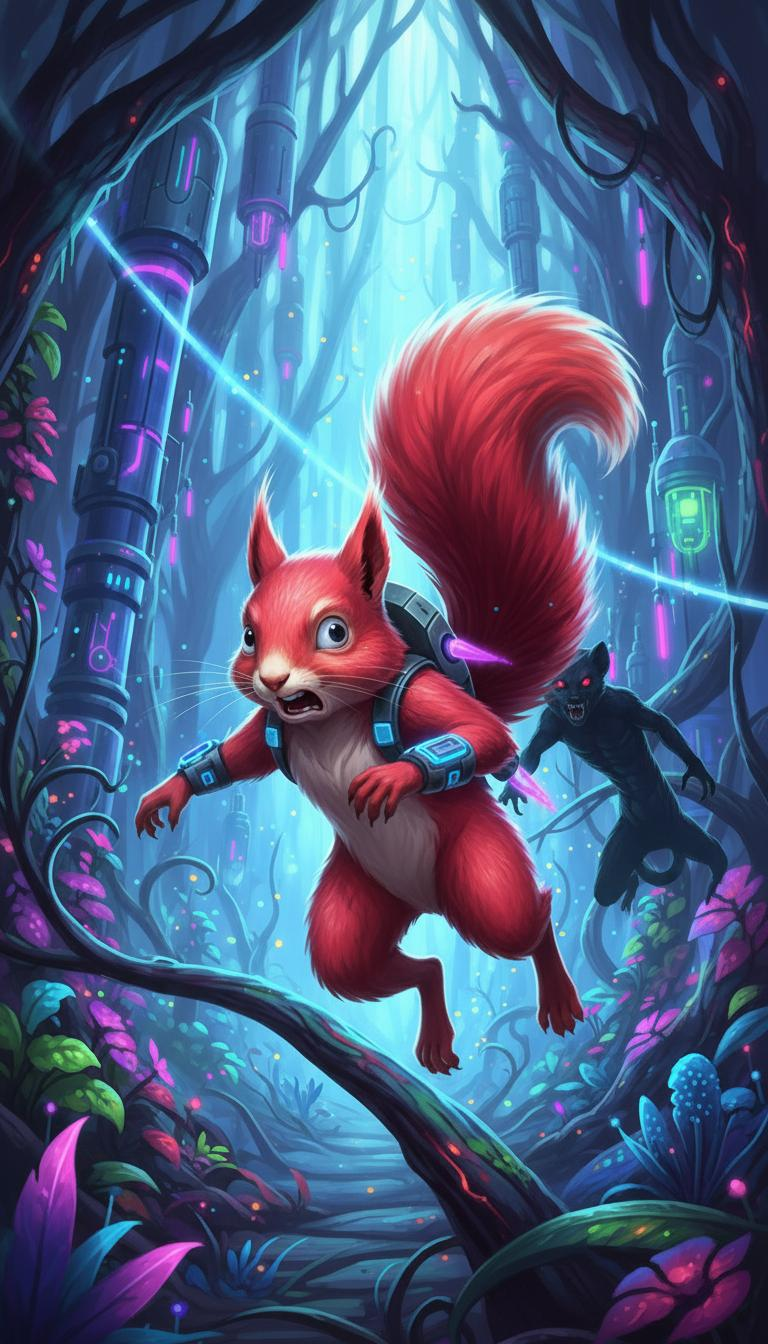

### Chapter 2: Chatterer's Last Chance

A tense moment in a vibrant, futuristic forest. Chatterer the Red Squirrel, a futuristic, anthropomorphic red squirrel with a sleek, vibrant red fur coat and minimalist sci-fi attire, has just pulled a long tail feather from Redtail the Hawk. Redtail, a majestic, futuristic Redtail Hawk with deep crimson and metallic feathers and cybernetic enhancements, is wide awake, feathers on its head flared with intense neon energy, and its sharp, predatory eyes glowing fiercely. Below, Shadow the Weasel, an unnervingly sleek and slender futuristic, anthropomorphic weasel with a dark, metallic body and neon red eyes, is startled and dodging around the tree trunk. Chatterer observes from a neighboring spruce tree, partially hidden by thick, glowing branches. The scene is bathed in saturated, vivid colors with dynamic neon lights. Art style: futuristic, science fiction, utopia, saturated, neon lights.

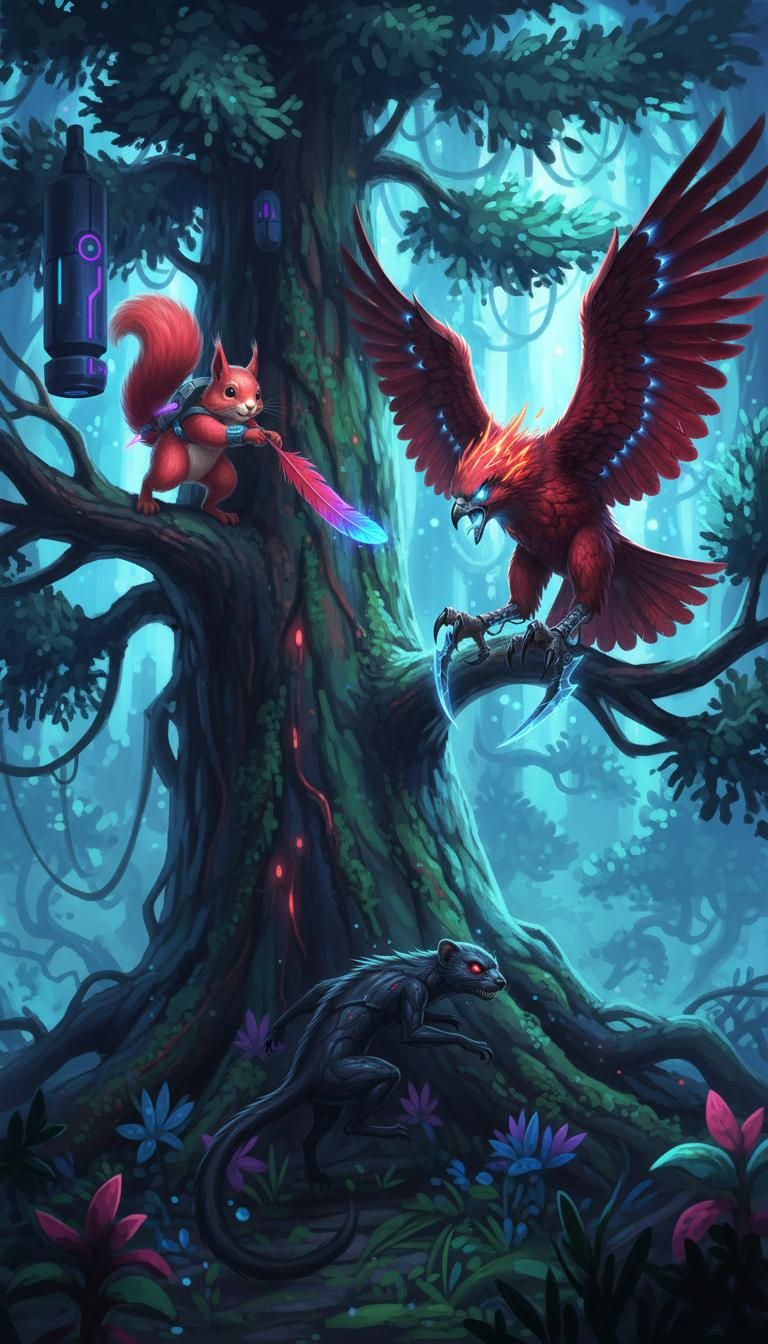

### Chapter 3: Chatterer Tells Sammy Jay About Shadow the Weasel

A conversation unfolds in a lush, neon-lit futuristic green forest. Chatterer the Red Squirrel, a futuristic, anthropomorphic red squirrel with a vibrant red fur coat and sci-fi attire, appears out of breath and somewhat dejected, speaking in a low, hesitant voice. Opposite him, perched on a glowing pine branch, is Sammy Jay, a futuristic, anthropomorphic Sammy Jay with vibrant, metallic blue feathers and a sleek communication device. Sammy's eyes, initially teasing, now show a more serious expression as he listens intently, his colorful feathers catching the saturated, vivid light of the utopian setting. Art style: futuristic, science fiction, utopia, saturated, neon lights.

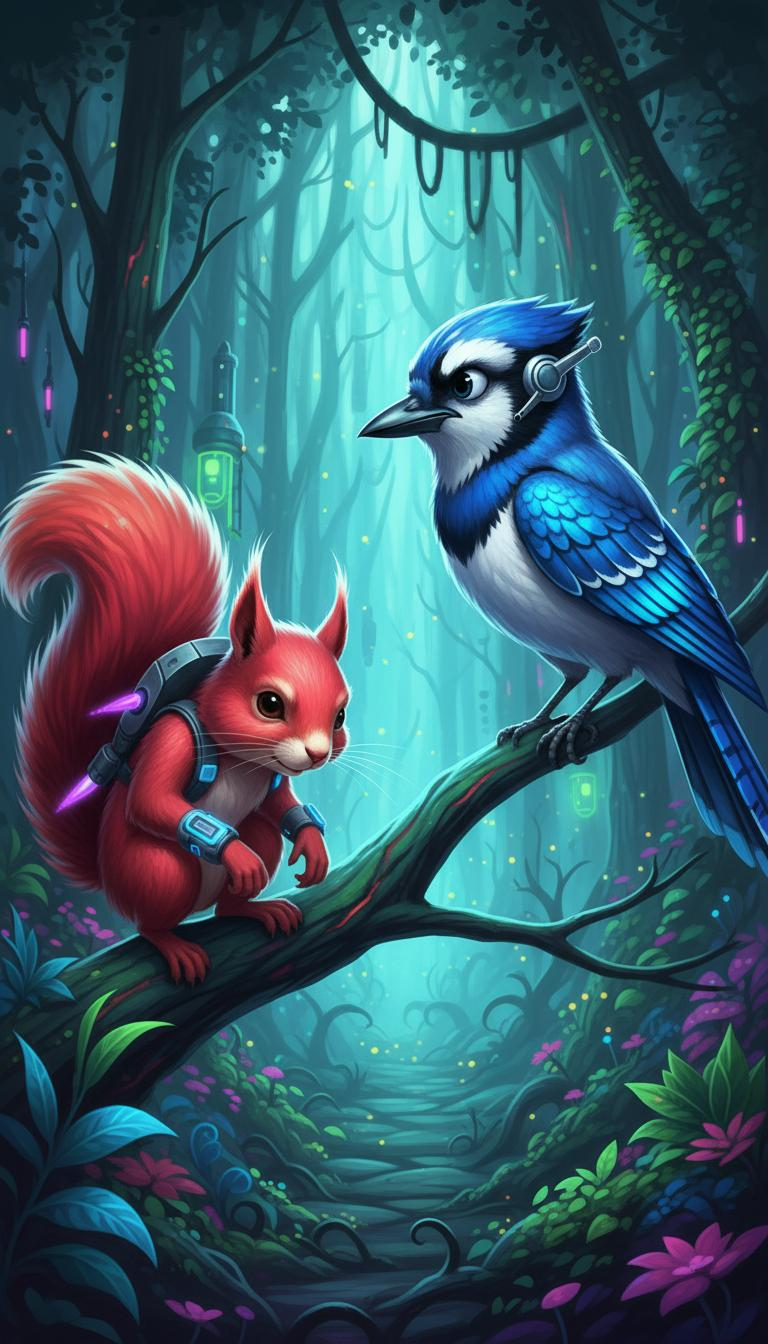

In [ ]:
image_chat.send_message("Starting from now, we're going to illustrate the book's chapters. Don't forget to refer to your previous illustrations of the characters to keep the characters consistency, but feel free to change their position.")

for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  response = image_chat.send_message(f"Create an illustration for {chapter['name']} using the previously generated characters following this description: {chapter['prompt']}")

  for part in response.parts:
    if part.inline_data:
      generated_image = part.as_image()
      generated_image.show()
      break

# Be careful; long output (see below)

# Next Steps
### Useful documentation references:

To improve your prompting skills, check the [prompt guide](https://ai.google.dev/gemini-api/docs/Gemini 2.5 Image-prompt-guide) for great advices on creating your prompts.

### Related examples

If you're curious about cool things you can build with Gemini 2.5 Image, check those great examples:
* [Zoom on earth](../examples/Zoom_on_earth.ipynb): Another take on mixing Gemini and Gemini 2.5 Image, this time using [function calling](./Function_calling.ipynb) to communicate.
* [Generative designs](../examples/Generative_designs.ipynb): This time Gemini will ingest a bunch of images to serve as models to generate model designs.

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.

You should also have a look at the [Live API](../quickstarts/Get_started_LiveAPI.ipynb) to create live intereactions with the models.
